# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [1]:
# import the necessary packages

from google.cloud import storage
import pandas as pd
import numpy as np
# show all columns
pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

In [2]:
# import function files and environment variables
import utils

# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [3]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data
raw_df_2001 = pd.read_sas(utils.read_cloud_data(bucket, '2001.sas7bdat'), format='sas7bdat') 
# raw_df_2002 = pd.read_csv(utils.read_cloud_data(bucket, '2002.tab'), sep='\t', lineterminator='\n')
# raw_df_2003 = pd.read_sas(utils.read_cloud_data(bucket, '2003.sas7bdat'), format='sas7bdat') 

In [6]:
df_2001 = utils.make_readable(raw_df_2001, variable_values_df)
# df_2002 = utils.make_readable(raw_df_2002.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)
# df_2003 = utils.make_readable(raw_df_2003.rename({'FY':'DataYear', 'FIPSCode':'FIPSCODE'}, axis=1), variable_values_df)

# Filter and Clean Data

In [7]:
# all_records = pd.concat([df_2001, df_2002, df_2003], axis=0)
all_records = df_2001.reset_index(drop=True) # temporarily doing 2001 only so that the code runs faster
all_records = utils.remove_nan_values(all_records)

Age Unknown: 0

Total Null Values: 2
Total Records: 813138
Total Columns: 61


In [8]:
all_records.notnull().sum()

DataYear               813138
RecNumbr               813136
MR                     813138
VISHEAR                813138
PHYDIS                 813138
                        ...  
dischargeReason        813138
raceEthnicity          813138
everAdopted            813138
diagnosedDisability    813138
age2021                813138
Length: 61, dtype: int64

In [10]:
# keep only the cases where the child has exited foster care
exited_df = all_records[all_records['Exited'] == 1]
print(exited_df.shape)

(268761, 61)


In [11]:
# Create Binary label for if they have reunified
exited_df['reunified'] = 0
exited_df.loc[(exited_df['Exited'] == 1) & (exited_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

/var/folders/x4/dl28z_rx30n4bp144tvcf38m0000gn/T/ipykernel_99077/186036490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exited_df['reunified'] = 0


# Baseline Model
## Everyone Reunifies

In [12]:
# Check to make sure the split is even
print(f"Reunified: {exited_df.reunified.value_counts()[0]}")
print(f"Not Reunified: {exited_df.reunified.value_counts()[1]}")
perc_reunified = exited_df.reunified.value_counts()[1] / exited_df.reunified.value_counts().sum()
print(f"\nPercentage Reunified: {round(perc_reunified*100, 2)}%")

Reunified: 120226
Not Reunified: 148535

Percentage Reunified: 55.27%


# Visualizing the data

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
chart_df = exited_df[exited_df['AgeAtEnd'] < 21]

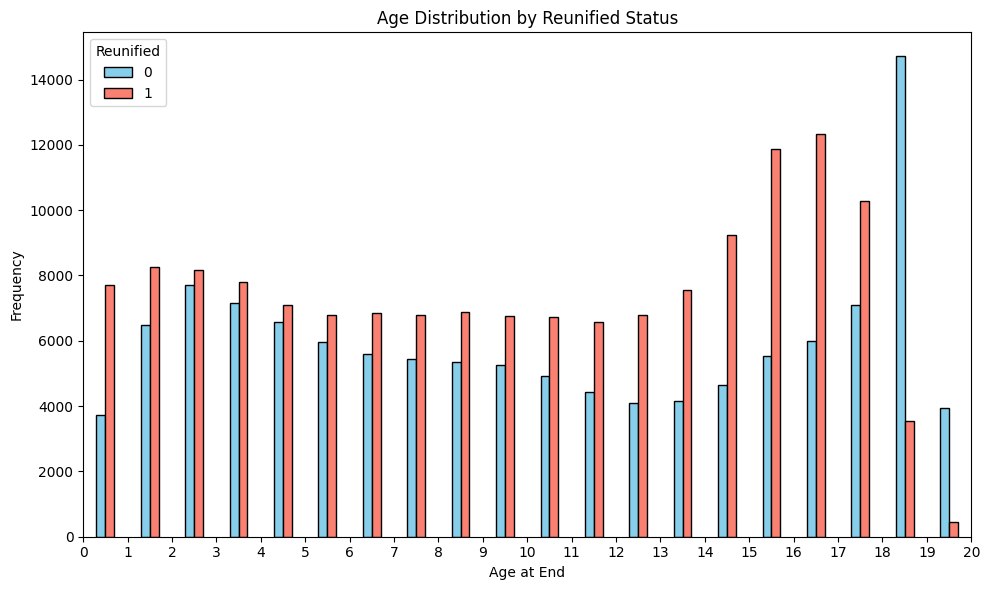

In [15]:
# Filter the DataFrame for each category in 'reunified'
group1 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[0]]['AgeAtEnd']
group2 = chart_df[chart_df['reunified'] == chart_df['reunified'].unique()[1]]['AgeAtEnd']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(chart_df['AgeAtEnd'], bins=20)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(chart_df['reunified'].unique()[0]), str(chart_df['reunified'].unique()[1])], 
         color=['skyblue', 'salmon'], edgecolor='black', rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified')
plt.xlabel('Age at End')
plt.ylabel('Frequency')
plt.title('Age Distribution by Reunified Status')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

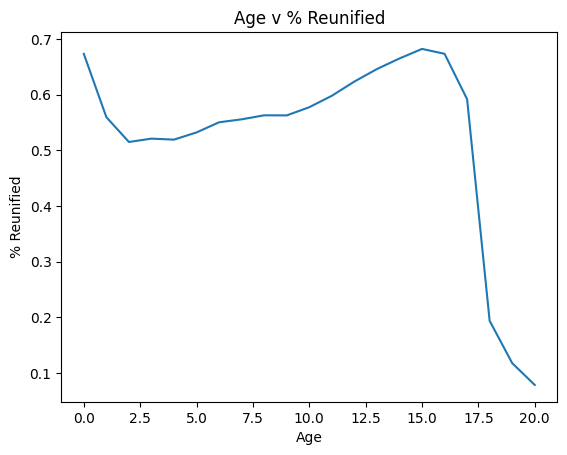

In [17]:
# plot age v % that reunified
age_reunified = chart_df.groupby('AgeAtEnd')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

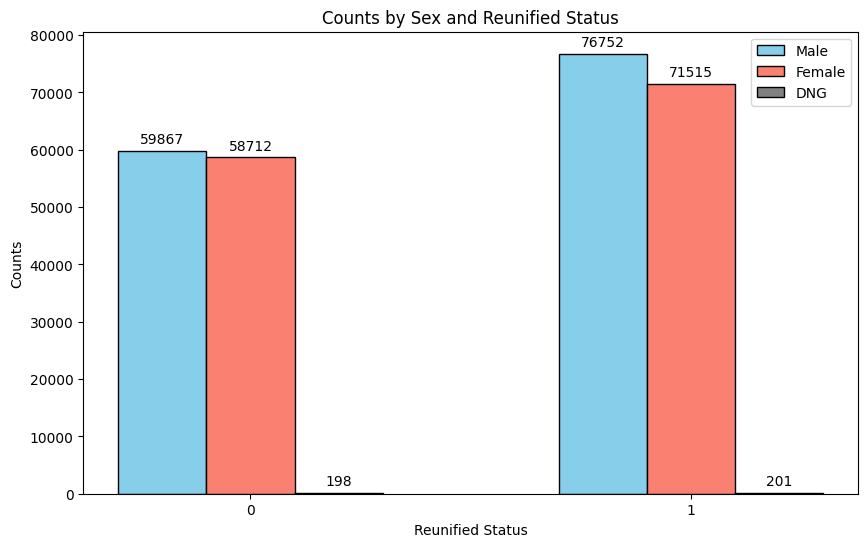

In [18]:
count_matrix = chart_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks(ind)
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


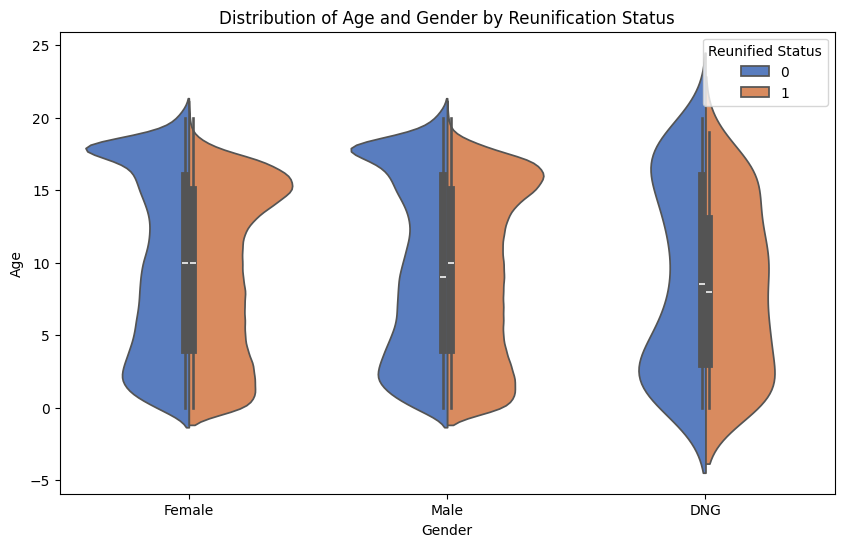

In [19]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AgeAtEnd", hue="reunified", data=chart_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Dataset for Model

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
ml_data_df = exited_df.drop(['DataYear', 'RecNumbr', 'dischargeReason', 'age2021'], axis=1)

In [22]:
ml_df = pd.get_dummies(ml_data_df, columns=['State', 'FIPSCode', 'Sex', 'removalManner', 'currentPlacementSetting', 'caseGoal', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement'])

In [23]:
X = ml_df.drop('reunified', axis=1)  # Features
y = ml_df['reunified']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = rf.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8776812456979145
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     23946
           1       0.86      0.93      0.89     29807

    accuracy                           0.88     53753
   macro avg       0.88      0.87      0.87     53753
weighted avg       0.88      0.88      0.88     53753



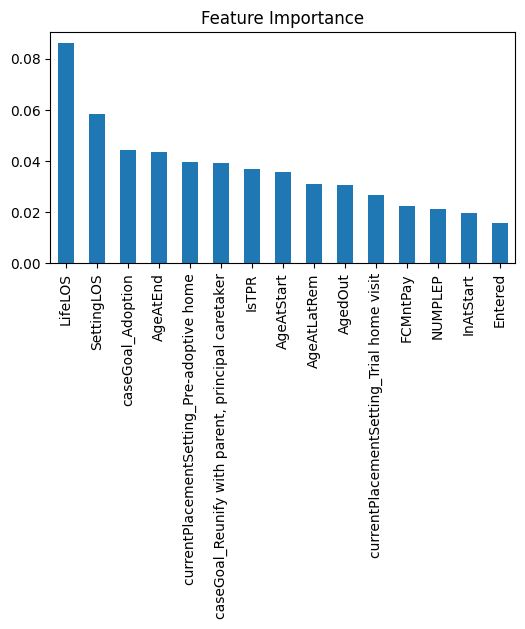

In [28]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:15].plot(kind='bar', figsize=(6, 3))
plt.title('Feature Importance')
plt.show()


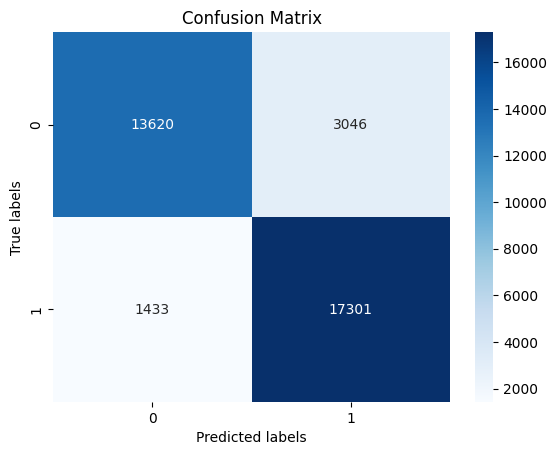

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

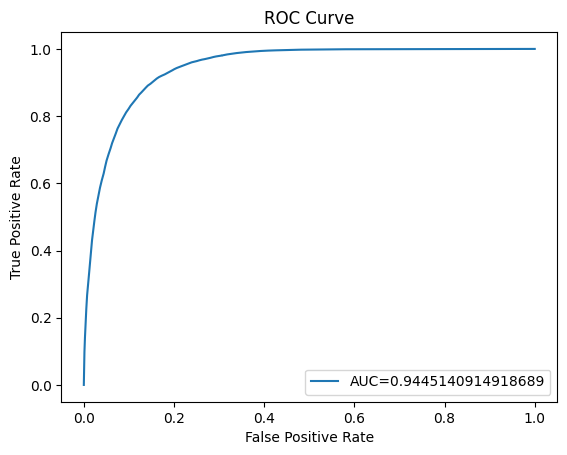

In [29]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

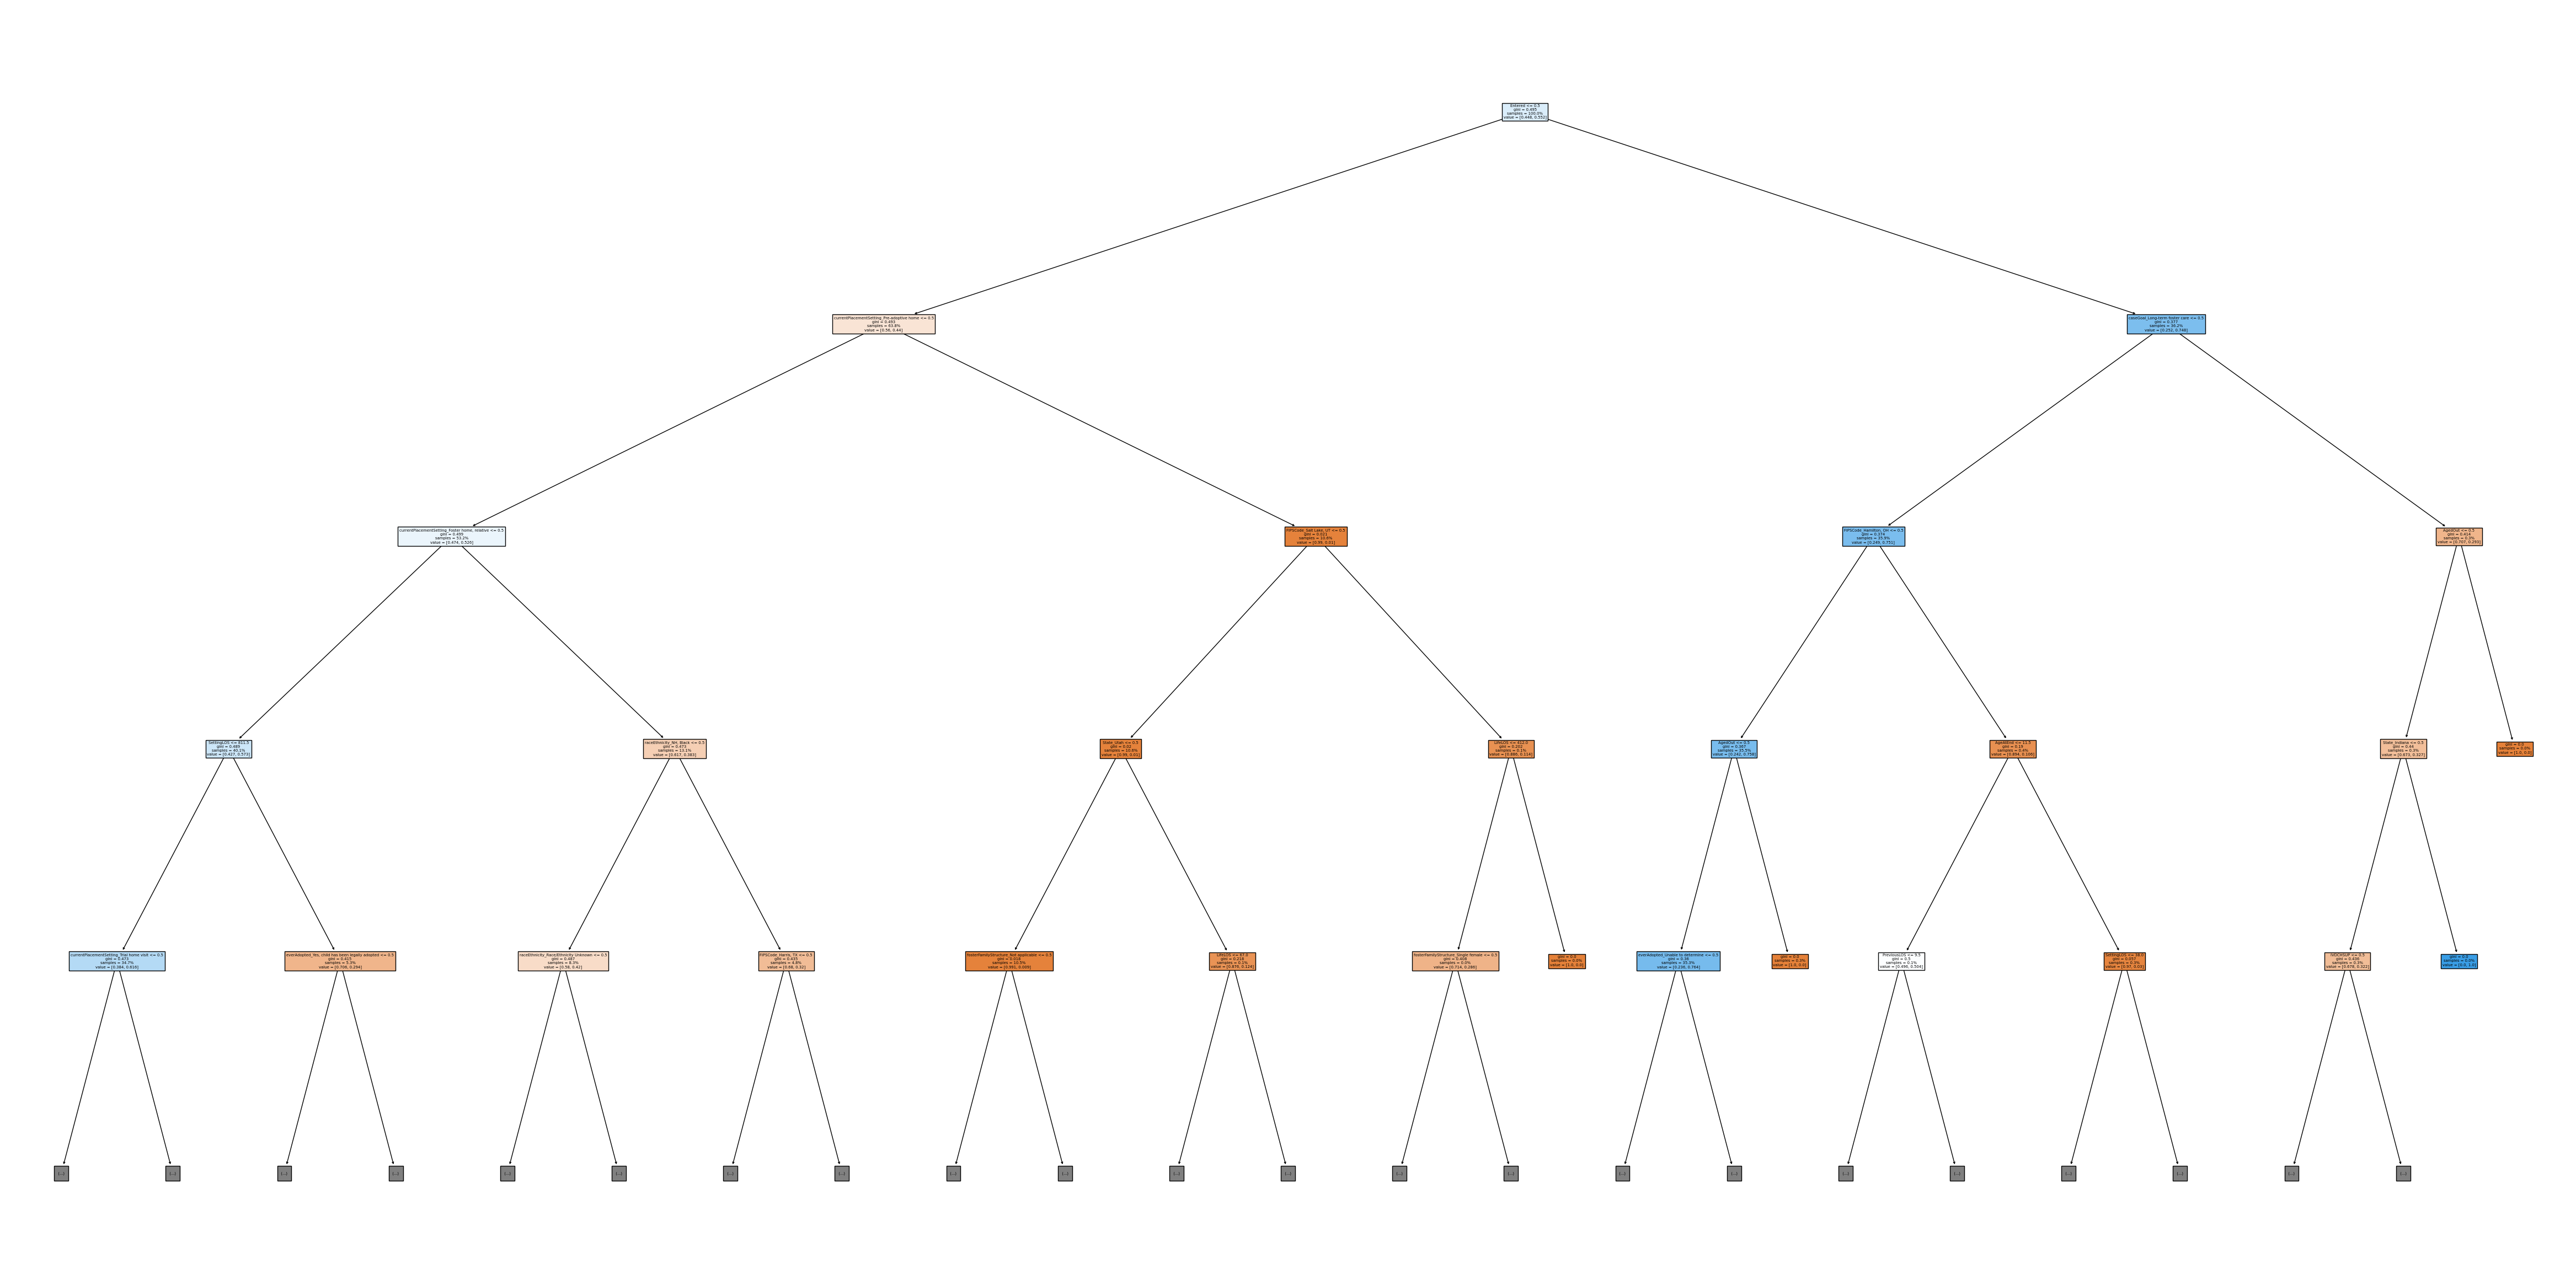

In [30]:
from sklearn.tree import plot_tree

# Pick a single tree from the forest
single_tree = rf.estimators_[0]

plt.figure(figsize=(60,30))
plot_tree(single_tree, filled=True, feature_names=X.columns, max_depth=4, proportion=True)
plt.show()

# XG Boost Model

In [31]:
import xgboost as xgb

# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [32]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8617937603482596
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     23946
           1       0.84      0.93      0.88     29807

    accuracy                           0.86     53753
   macro avg       0.87      0.85      0.86     53753
weighted avg       0.87      0.86      0.86     53753



In [77]:
# from sklearn.model_selection import GridSearchCV

# xgb_model = xgb.XGBClassifier()
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(grid_search.best_params_)
# print(grid_search.best_score_)

/Users/sophiechance/Documents/Cal/Github/foster_care_analysis/foster_venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
0.8593967097612492


# KNN Model

In [33]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.714918237121649
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     23946
           1       0.73      0.78      0.75     29807

    accuracy                           0.71     53753
   macro avg       0.71      0.71      0.71     53753
weighted avg       0.71      0.71      0.71     53753



# CNN Model

In [34]:
import tensorflow as tf

In [35]:
age = np.array(X_train['AgeAtEnd'])[10:20]
print("Ages:", age)

age_bins = [0, 5, 10, 15, 20]
age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
print("Age Bins:", age_binned)

age_id = tf.keras.layers.IntegerLookup(vocabulary=np.arange(0, len(age_bins)+1), output_mode='one_hot')(age_binned)
print('Ages as one-hot:', age_id)

Ages: [13.  4. 12. 16.  4. 17. 11. 12.  1. 11.]
Age Bins: tf.Tensor([3 1 3 4 1 4 3 3 1 3], shape=(10,), dtype=int64)
Ages as one-hot: tf.Tensor(
[[0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]], shape=(10, 7), dtype=int64)


In [125]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')

    age_bins = [0, 5, 10, 15, 20, 30]
    age_binned = tf.keras.layers.Discretization(bin_boundaries=age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(age_bins)+1),
        output_mode='one_hot')(age_binned)
    
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    features = tf.keras.layers.Concatenate()([age_id, sex_id])

    dense = tf.keras.layers.Dense(
        units=12, activation='tanh', name='hidden1')(features)

    reunified = tf.keras.layers.Dense(
        units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[age, sex], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [126]:
model = build_model()
history = model.fit(
    x = {
        'Age': ml_data_df['AgeAtEnd'], 
        'Sex': ml_data_df['Sex']
        },
    y = ml_data_df['reunified'],
    validation_data=(
        {
            'Age': ml_data_df['AgeAtEnd'], 
            'Sex': ml_data_df['Sex']
        },
        ml_data_df['reunified']),
    epochs=10,
    batch_size=32
)

Epoch 1/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 5s 745us/step - accuracy: 0.5320 - loss: 0.6893 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 2/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 748us/step - accuracy: 0.5406 - loss: 0.6815 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 3/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 725us/step - accuracy: 0.5409 - loss: 0.6814 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 4/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 721us/step - accuracy: 0.5413 - loss: 0.6814 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 5/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 714us/step - accuracy: 0.5416 - loss: 0.6814 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 6/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 720us/step - accuracy: 0.5417 - loss: 0.6814 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 7/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 714us/step - accuracy: 0.5423 - loss: 0.6813 - val_accuracy: 0.5440 - val_loss: 0.6814
Epoch 8/10
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 4s 713us/step - accuracy: 0.5424 -

In [ ]:
print("Concatenate - Accuracy: 0.5439")